In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [17]:
filepath = '/content/timeseriesdata.csv'
df = pd.read_csv(filepath)
df

,Quarter,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,1990 1Q,24.3,74.7,"16,669.50","2,647,627",61.907,1.8843,16.113111,31600,1458.400000
1,1990 2Q,24.4,70.5,"17,087.70","2,677,041",62.501,1.8396,16.999927,31600,1527.000000
2,1990 3Q,25.0,73.8,"17,930.10","2,706,454",63.181,1.7632,17.886744,31600,1098.700000
3,1990 4Q,24.7,84.9,"18,805","2,735,868",63.969,1.7445,18.773560,31600,1154.800000
4,1991 1Q,24.9,80.5,"18,521","2,750,577",64.249,1.7931,19.660376,31600,1490.800000
...,...,...,...,...,...,...,...,...,...,...
91,2012 4Q,146.7,98.3,"94,848.80","3,818,205",97.936,1.2221,113.643019,63500,3167.080078
92,2013 1Q,148.6,101.0,"93,773","3,824,842",98.574,1.2436,114.828898,65700,3308.100098
93,2013 2Q,149.4,88.5,"95,587.20","3,831,478",97.656,1.2652,115.705388,67900,3150.439941
94,2013 3Q,148.1,89.3,"96,028.30","3,838,115",98.865,1.2572,116.581878,63300,3167.870117


In [18]:
def todatetime(row):
    row['Quarter'] = row['Quarter'].replace(' 1Q', '-03')
    row['Quarter'] = row['Quarter'].replace(' 2Q', '-06')
    row['Quarter'] = row['Quarter'].replace(' 3Q', '-09')
    row['Quarter'] = row['Quarter'].replace(' 4Q', '-12')
    
    return row

df1 = df.apply(todatetime, axis='columns')
df1['Quarter'] = pd.to_datetime(df1['Quarter'], infer_datetime_format = True)

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Quarter               96 non-null     datetime64[ns]
 1   hdbrpi                96 non-null     float64       
 2   labour-cost           96 non-null     float64       
 3   gdp                   96 non-null     object        
 4   population            96 non-null     object        
 5   cpi                   96 non-null     float64       
 6   exchange-rate         96 non-null     float64       
 7   consumer-spending     96 non-null     float64       
 8   overall unemployment  96 non-null     int64         
 9   sti                   96 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 7.6+ KB


In [20]:
def tofloat(row):
    row['gdp'] = row['gdp'].replace(',', '')
    row['population'] = row['population'].replace(',', '')
    return row

df2 = df1.apply(tofloat, axis='columns')
df2['gdp'] = df2['gdp'].astype(float)
df2['population'] = df2['population'].astype(float)
df2['overall unemployment'] = df2['overall unemployment'].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Quarter               96 non-null     datetime64[ns]
 1   hdbrpi                96 non-null     float64       
 2   labour-cost           96 non-null     float64       
 3   gdp                   96 non-null     float64       
 4   population            96 non-null     float64       
 5   cpi                   96 non-null     float64       
 6   exchange-rate         96 non-null     float64       
 7   consumer-spending     96 non-null     float64       
 8   overall unemployment  96 non-null     float64       
 9   sti                   96 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 7.6 KB


In [21]:
df3 = df2.drop(columns = 'Quarter')
df3

,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,24.3,74.7,16669.5,2647627.0,61.907,1.8843,16.113111,31600.0,1458.400000
1,24.4,70.5,17087.7,2677041.0,62.501,1.8396,16.999927,31600.0,1527.000000
2,25.0,73.8,17930.1,2706454.0,63.181,1.7632,17.886744,31600.0,1098.700000
3,24.7,84.9,18805.0,2735868.0,63.969,1.7445,18.773560,31600.0,1154.800000
4,24.9,80.5,18521.0,2750577.0,64.249,1.7931,19.660376,31600.0,1490.800000
...,...,...,...,...,...,...,...,...,...
91,146.7,98.3,94848.8,3818205.0,97.936,1.2221,113.643019,63500.0,3167.080078
92,148.6,101.0,93773.0,3824842.0,98.574,1.2436,114.828898,65700.0,3308.100098
93,149.4,88.5,95587.2,3831478.0,97.656,1.2652,115.705388,67900.0,3150.439941
94,148.1,89.3,96028.3,3838115.0,98.865,1.2572,116.581878,63300.0,3167.870117


In [22]:
dataX = df3.drop(columns=['hdbrpi'])
dataX = dataX.to_numpy()

In [23]:
dataY = df3['hdbrpi']
dataY = dataY.to_numpy().reshape(96, 1)

In [117]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(dataX, dataY, test_size=0.15, random_state=0, shuffle=False)

In [118]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [119]:
num_features = 8

In [120]:
print(Xtrain_scaled.shape)
print(Xtest_scaled.shape)
print(Ytrain.shape)
print(Ytest.shape)

(81, 8)
(15, 8)
(81, 1)
(15, 1)


In [121]:
Xtrain_scaled[0]

array([-1.84084637, -1.52157965, -1.94547663, -2.11405907,  1.94027159,
       -1.59798334, -1.04617237, -0.94563352])

In [122]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(num_features,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
#model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dense(6, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dense(6, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

In [123]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(Xtrain_scaled, Ytrain, epochs=200, validation_data=(Xtest_scaled, Ytest), batch_size=6)

Epoch 1/200
14/14 [==============================] - 1s 15ms/step - loss: 5490.1681 - mean_absolute_error: 70.6403 - val_loss: 17357.5039 - val_mean_absolute_error: 131.3880
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 5126.8692 - mean_absolute_error: 68.2293 - val_loss: 15989.2705 - val_mean_absolute_error: 126.1178
Epoch 3/200
14/14 [==============================] - 0s 5ms/step - loss: 4464.7576 - mean_absolute_error: 61.5121 - val_loss: 13927.0801 - val_mean_absolute_error: 117.7255
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 4168.4806 - mean_absolute_error: 60.2436 - val_loss: 11389.2754 - val_mean_absolute_error: 106.4861
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 4053.1593 - mean_absolute_error: 59.1796 - val_loss: 7840.4946 - val_mean_absolute_error: 88.3793
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 3312.6353 - mean_absolute_error: 51.4174 - val_loss: 4487.7285 

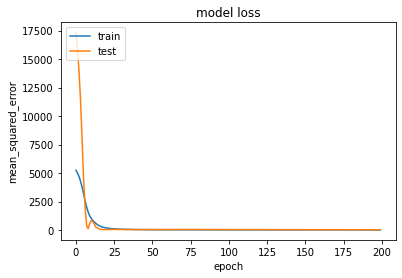

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
print("train MSE", min(history.history['loss']))
print("val MSE", min(history.history['val_loss']))

train MSE 12.874077796936035
val MSE 27.25636863708496


In [126]:
print("train MSE", history.history['loss'][-1])
print("val MSE", history.history['val_loss'][-1])

train MSE 12.874077796936035
val MSE 27.25636863708496


In [127]:
Xtest_scaled.shape

(15, 8)

In [128]:
X = np.concatenate((Xtrain_scaled, Xtest_scaled), axis=0)
print(X.shape)
Y = dataY
print(Y.shape)

(96, 8)
(96, 1)


In [132]:
Y_pred = model.predict(X)

In [133]:
Y_pred.shape

(96, 1)

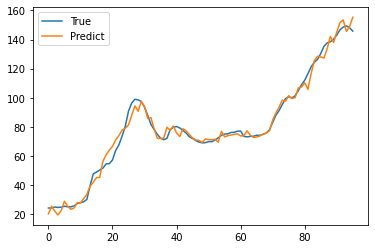

In [134]:
plt.plot(Y, label='True')
plt.plot(Y_pred,  label='Predict')
plt.legend()
plt.show()

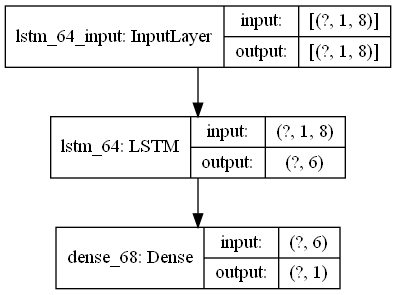

In [ ]:
tf.keras.utils.plot_model(model, to_file='modelfund.png', show_shapes=True)

In [91]:
dataX.shape

(96, 8)

In [92]:
dataY.shape

(96, 1)

In [93]:
dx = dataX[:-1]
dx.shape

(95, 8)

In [94]:
dy=dataY[1:]
dy.shape

(95, 1)

In [95]:
X_tr, X_te, Y_tr, Y_te = train_test_split(dx, dy, test_size=0.15, random_state=0, shuffle=True)

In [96]:
model2 = keras.Sequential()
model2.add(tf.keras.layers.Dense(16, activation = 'relu', input_shape = (8,)))
model2.add(tf.keras.layers.Dense(1))

In [97]:
model2.compile(optimizer = 'adam', loss = 'mean_squared_error')
history2 = model2.fit(X_tr, Y_tr, epochs=200, validation_data=(X_te, Y_te), batch_size=6)

Epoch 1/200
14/14 [==============================] - 0s 13ms/step - loss: 16544463940.2667 - val_loss: 1286314752.0000
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 530963846.4000 - val_loss: 661983424.0000
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 609602434.1333 - val_loss: 130807008.0000
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 62926114.1333 - val_loss: 48584552.0000
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 52022490.9333 - val_loss: 16555325.0000
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 15642520.6000 - val_loss: 20086516.0000
Epoch 7/200
14/14 [==============================] - 0s 4ms/step - loss: 15850101.6667 - val_loss: 15327429.0000
Epoch 8/200
14/14 [==============================] - 0s 4ms/step - loss: 13412425.0667 - val_loss: 15353939.0000
Epoch 9/200
14/14 [==============================] - 0s 4ms/step - loss: 15152395.8000

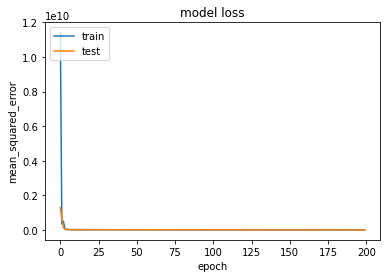

In [98]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
print("train MSE", min(history2.history['loss']))
print("val MSE", min(history2.history['val_loss']))

train MSE 242591.203125
val MSE 263153.5


In [ ]:
print("train MSE", history2.history['loss'][-1])
print("val MSE", history2.history['val_loss'][-1])

train MSE 47402980.0
val MSE 52075128.0
